<img src="icons/icon.png" width="50"/> ![Badge](https://img.shields.io/badge/Workshop%20SMLMS%202025-FF1010?style=for-the-badge)
## Single Molecule Tracking and Diffusion

 *[Daniel Sage](mailto:daniel.sage@epfl.ch?subject=Single%20Molecule%20Tracking%20and%20Diffusion), Ecole Polytechnique Fédérale de Lausanne, Switerzland*


# Simulation of Brownian Motion
```
- Isotropic diffusion
- Anisotropic diffusion
- Non-homogeneous diffusion
```


In [10]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# ------------------ General parameters of the simulator ------------------
N_PARTICLES = 25              # Number of particles 
N_PARTICLES_PLOTTED = 8       # Number of displayed particles in the plots
STEPS = 25                # Number of steps of the trajectory 
DT = 1                    # Time sample step, unitless
FOV = (100, 120)          # Dimension of the squared field of view
MIN_LENGTH_TRAJECTORY = 6 # Minimal duration of the trajectory to compute the MSD

rng = np.random.default_rng(1234) # Random generator with a seed
FOV = np.array(FOV)

### Functions to compute the MSD and fit the diffusion coefficient D

In [11]:
def msd_model(t, D):
    return 4 * D * t  # 2D Brownian motion

def mean_square_displacement(trajectory):
    duration = len(trajectory)
    msd = np.zeros(duration)
    traj = np.array(trajectory)
    for t in range(duration):
        dx = traj[t:,0] - traj[:duration-t,0]
        dy = traj[t:,1] - traj[:duration-t,1]
        displacements = dx**2 + dy**2
        msd[t] = np.mean(displacements)
    return msd

def compute_msd(trajectories):
    msds = []
    for trajectory in trajectories:
        msds.append(mean_square_displacement(trajectory))
    return msds
    
def fit_diffusion(msds, DT=1):
    Ds = []
    for msd in msds:
        time = np.arange(len(msd)) * DT
        popt, _ = curve_fit(msd_model, time[1:], msd[1:], p0=(1.0,), maxfev=10000) 
        Ds.append(popt[0])
    return np.array(Ds)

### Functions to plot trajectories and MSD

In [12]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

cmap = plt.colormaps['inferno'].resampled(N_PARTICLES_PLOTTED)   # modern API
colors = cmap(np.linspace(0, 1, N_PARTICLES_PLOTTED)) 

def plot_trajectories_item_color_coded(ax, trajectories, colors, N_PARTICLES_PLOTTED, FOV, prefix=''):
    starts = [] 
    for i in range(min(len(trajectories), N_PARTICLES_PLOTTED)):
        P = np.stack(trajectories[i])
        x, y = P[:,0], P[:,1]
        starts.append(P[0])
        ax.plot(x, y, color=colors[i], label=f"P{i}")
    starts = np.vstack(starts)
    ax.scatter(starts[:,0], starts[:,1], s=6, facecolors='none', edgecolors='blue', linewidths=1.5)
    ax.set_xlim((0,FOV[0]))
    ax.set_ylim((0,FOV[1])) 
    ax.set_title(f"{prefix} Motion Trajectories (first {N_PARTICLES_PLOTTED})")

def plot_trajectories_time_color_coded(ax, trajectories, N_PARTICLES_PLOTTED, FOV, prefix=''):              
    starts = [] 
    for i in range(min(len(trajectories), N_PARTICLES_PLOTTED)):
        P = np.stack(trajectories[i])
        starts.append(P[0])
        t = np.arange(len(P))*DT
        segments = np.stack([P[:-1], P[1:]], axis=1)
        t_seg = 0.5*(t[:-1] + t[1:])
        norm = Normalize(vmin=t.min(), vmax=t.max(), clip=True)
        lc = LineCollection(segments, cmap='viridis', norm=norm, linewidth=1.5)
        lc.set_array(t_seg)
        ax.add_collection(lc)
    starts = np.vstack(starts)
    ax.scatter(starts[:,0], starts[:,1], s=6, facecolors='none', edgecolors='blue', linewidths=1.5)
    ax.set_xlim((0,FOV[0]))
    ax.set_ylim((0,FOV[1])) 
    ax.set_title(f"{prefix} Motion Trajectories (first {N_PARTICLES_PLOTTED})")
 
def plot_msd_diffusion(ax, msds, Ds, colors, N_PARTICLES_PLOTTED, prefix=''):
    for i in range(min(len(msds), N_PARTICLES_PLOTTED)):
        msd = msds[i]
        time = np.arange(len(msd)) * DT
        ax.plot(time, msd, color=colors[i], label=f"P{i}")
        if not np.isnan(Ds[i]):
            ax.plot(time, 4 * Ds[i] * time, '--', color=colors[i], label=f"P{i} fit (D ≈ {Ds[i]:.2f})")

    mean_D = np.mean(Ds)
    std_D = np.std(Ds)
    ax.set_title(f"{prefix} - MSD with Fitted D (first {N_PARTICLES_PLOTTED})")
    ax.grid(True)
    ax.text(0.45, 0.90, f"Mean D  ≈ {mean_D:.4f}\nStdev ≈ {std_D:.4f}", transform=ax.transAxes, fontsize=12)

def plot_displacement_vectors(ax, trajectories, colors, N_PARTICLES_PLOTTED, prefix=''):
    for i in range(min(len(trajectories), N_PARTICLES_PLOTTED)):
        P = np.stack(trajectories[i])
        dx = np.diff(P[:,0])
        dy = np.diff(P[:,1])
        for k in range(dx.shape[0]):
            ax.arrow(0, 0, dx[k], dy[k], head_width=0.01, alpha=0.5, color=colors[i])
    ax.set_title('Displacement Vectors')
    ax.grid(True)
    ax.axis('equal')

### Isotropic Brownian Motion

Generated 25 trajectories - Average length 25.00000


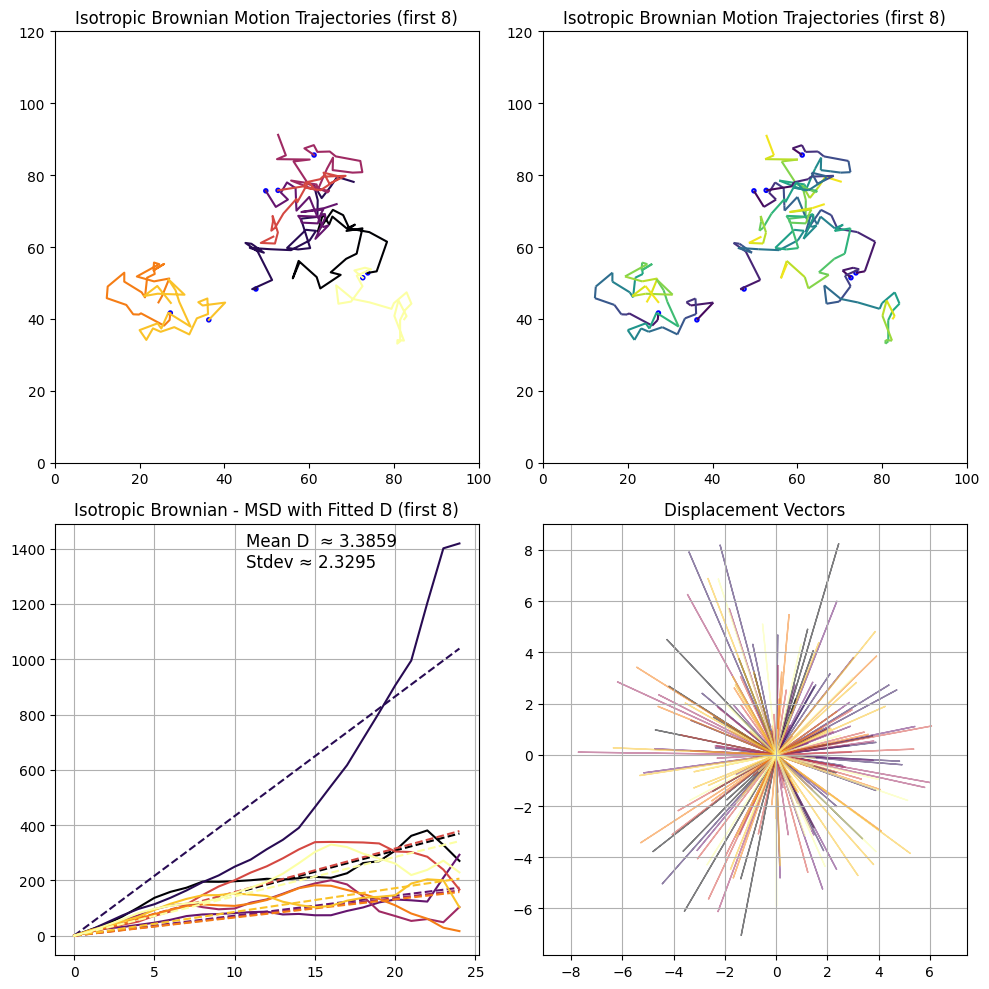

In [13]:
D_TRUE = 4  # True diffusion coefficient

def generate_isotropic_brownian_trajectory(N, steps, dt, D):
    trajectories = []
    for i in range(N):
        trajectory = [rng.uniform(FOV/4, 3*FOV/4)] # Starting position in the center
        for t in range(1, steps):
            position = trajectory[- 1] + rng.normal(0.0, 1.0, size=2) * np.sqrt(2 * D * dt)
            if np.all((position < 0) & (position >= FOV)): break
            trajectory.append(position)
        if len(trajectory) > MIN_LENGTH_TRAJECTORY: 
            trajectories.append(trajectory)
        else:
            print(f'Trajectory {i} is too short {len(trajectory)}')
    print(f'Generated {len(trajectories)} trajectories - Average length {np.mean([len(tr) for tr in trajectories]):3.5f}')
    return trajectories

trajectories = generate_isotropic_brownian_trajectory(N_PARTICLES, STEPS, DT, D_TRUE)
msds = compute_msd(trajectories)
Ds = fit_diffusion(msds, DT)

name = 'Isotropic Brownian'
fig, ((ax00, ax01), (ax10, ax11)) = plt.subplots(2, 2, figsize=(10, 10))
plot_trajectories_item_color_coded(ax00, trajectories, colors, N_PARTICLES_PLOTTED, FOV, name)
plot_trajectories_time_color_coded(ax01, trajectories, N_PARTICLES_PLOTTED, FOV, name)
plot_displacement_vectors(ax11, trajectories, colors, N_PARTICLES_PLOTTED, name)
plot_msd_diffusion(ax10, msds, Ds, colors, N_PARTICLES_PLOTTED, name)
plt.tight_layout()
plt.show()

### Anisotropic Brownian Motion

Generated 25 trajectories - Average length 25.00000


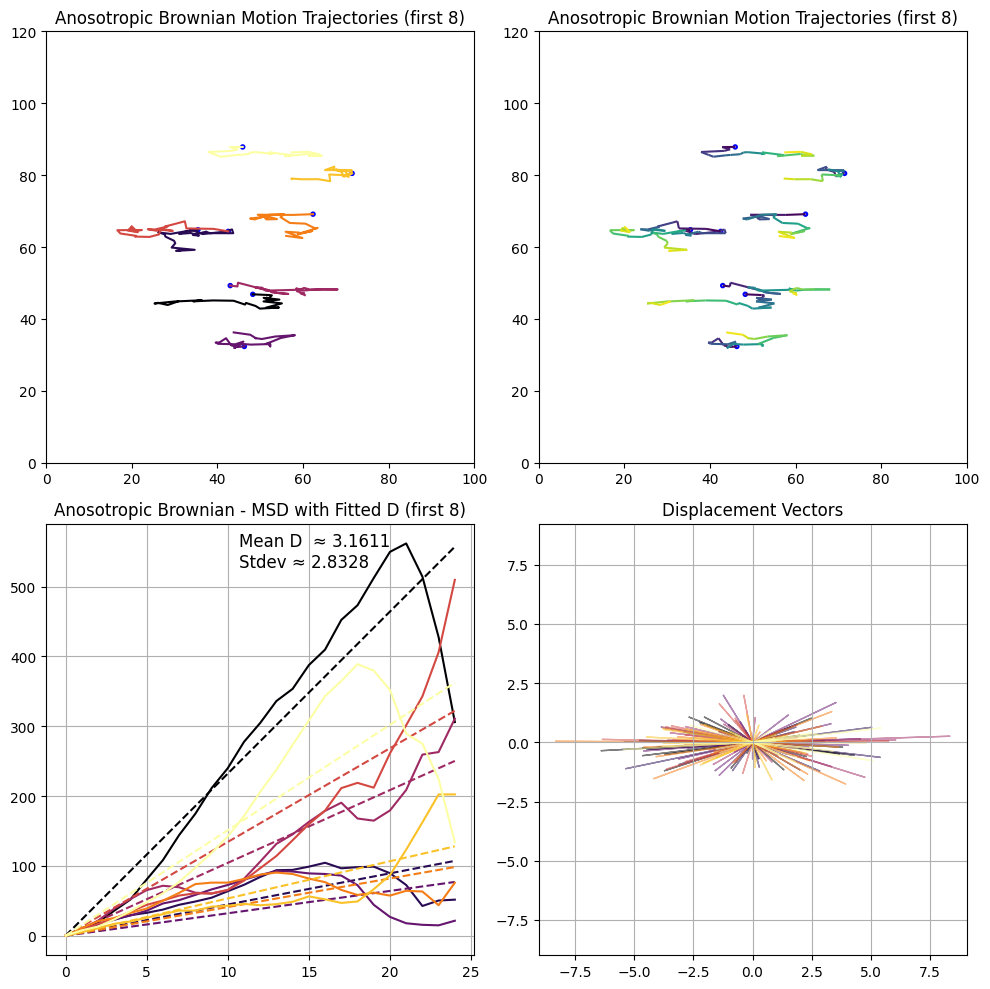

In [14]:
D1 = 4       # diffusion along principal axis 1
D2 = 0.25      # diffusion along principal axis 2
THETA = np.pi/6  # orientation angle (radians)

def generate_anisotropic_trajectory(N, steps, dt, D1, D2, THETA):

    R = np.array([[np.cos(THETA), -np.sin(THETA)],[np.sin(THETA), np.cos(THETA)]])
    sig = np.sqrt(2.0 * dt * np.array([D1, D2]))  # [σ1, σ2] Std devs along principal axes

    trajectories = []
    for i in range(N):
        trajectory = [rng.uniform(FOV/4, 3*FOV/4)] # Starting position in the center
        for t in range(1, steps):
            # independent normals along principal axes then rotate
            position = trajectory[-1] + (R @ rng.normal(0.0, 1.0, size=2) * sig)
            if np.all((position < 0) & (position >= FOV)): break
            trajectory.append(position)
        if len(trajectory) > MIN_LENGTH_TRAJECTORY: 
            trajectories.append(trajectory)
        else:
            print(f'Trajectory {i} is too short {len(trajectory)}')
    print(f'Generated {len(trajectories)} trajectories - Average length {np.mean([len(tr) for tr in trajectories]):3.5f}')

    return trajectories

trajectories = generate_anisotropic_trajectory(N_PARTICLES, STEPS, DT, D1, D2, THETA)
msds = compute_msd(trajectories)
Ds = fit_diffusion(msds, DT)

name = 'Anosotropic Brownian'
fig, ((ax00, ax01), (ax10, ax11)) = plt.subplots(2, 2, figsize=(10, 10))
plot_trajectories_item_color_coded(ax00, trajectories, colors, N_PARTICLES_PLOTTED, FOV, name)
plot_trajectories_time_color_coded(ax01, trajectories, N_PARTICLES_PLOTTED, FOV, name)
plot_displacement_vectors(ax11, trajectories, colors, N_PARTICLES_PLOTTED, name)
plot_msd_diffusion(ax10, msds, Ds, colors, N_PARTICLES_PLOTTED, name)
plt.tight_layout()
plt.show()

### Non-homogeneous Brownian Motion

Generated 25 trajectories - Average length 25.00000


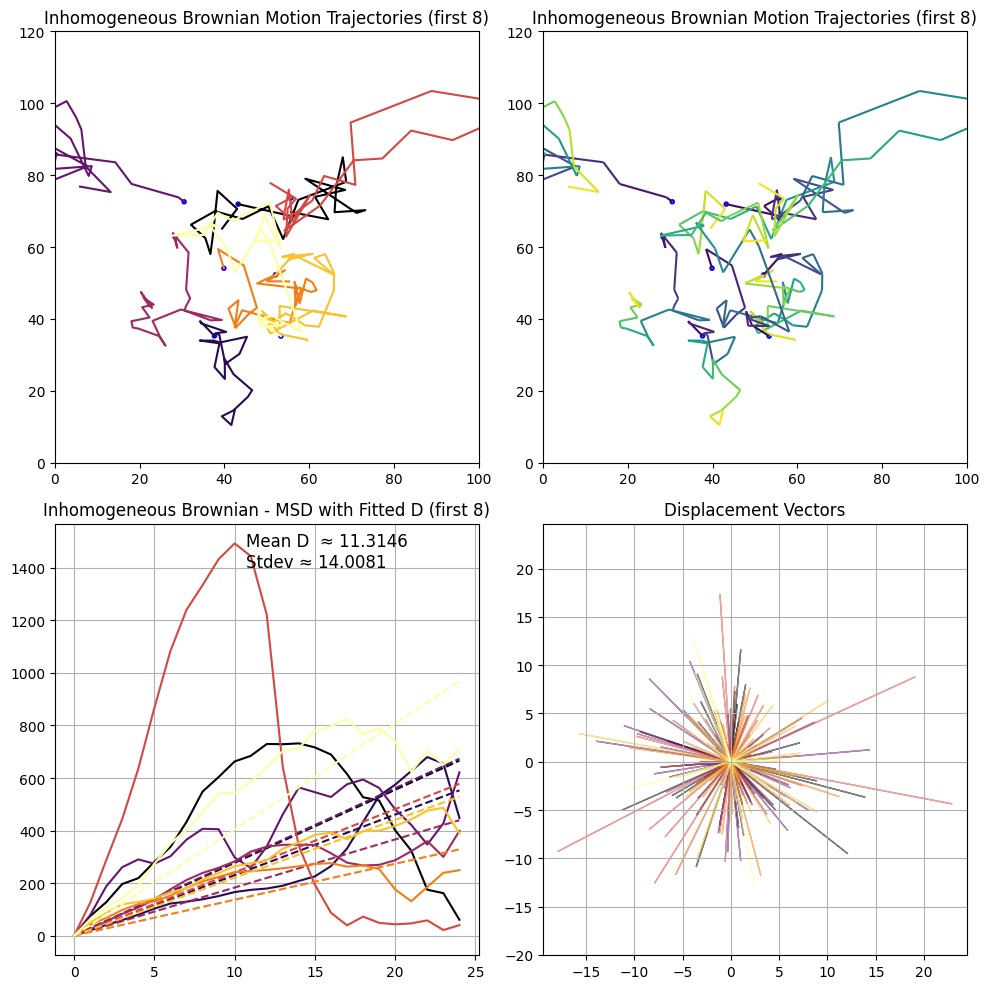

In [15]:
def D_space(x, y):
    # Diffusion increases with distance from the origin
    r = np.sqrt(x**2 + y**2)
    return 0.1 + 0.07 * r
    
def generate_nonhomogeneous_trajectory(N, steps, dt, D_func):
    trajectories = []
    for i in range(N):
        trajectory = [rng.uniform(FOV/4, 3*FOV/4)] # Starting position in the center
        for t in range(1, steps):
            x, y = trajectory[-1]
            D_inhomogeneous = D_func(x, y) * dt  # <-- D depends on current position    
            position = trajectory[-1] + (rng.normal(0.0, 1.0, size=2)  * D_inhomogeneous)
            if np.all((position < 0) & (position >= FOV)): break
            trajectory.append(position)
        if len(trajectory) > MIN_LENGTH_TRAJECTORY: 
            trajectories.append(trajectory)
        else:
            print(f'Trajectory {i} is too short {len(trajectory)}')
    print(f'Generated {len(trajectories)} trajectories - Average length {np.mean([len(tr) for tr in trajectories]):3.5f}')
    return trajectories

trajectories = generate_nonhomogeneous_trajectory(N_PARTICLES, STEPS, DT, D_space)
msds = compute_msd(trajectories)
Ds = fit_diffusion(msds, DT)

name = 'Inhomogeneous Brownian'
fig, ((ax00, ax01), (ax10, ax11)) = plt.subplots(2, 2, figsize=(10, 10))
plot_trajectories_item_color_coded(ax00, trajectories, colors, N_PARTICLES_PLOTTED, FOV, name)
plot_trajectories_time_color_coded(ax01, trajectories, N_PARTICLES_PLOTTED, FOV, name)
plot_displacement_vectors(ax11, trajectories, colors, N_PARTICLES_PLOTTED, name)
plot_msd_diffusion(ax10, msds, Ds, colors, N_PARTICLES_PLOTTED, name)
plt.tight_layout()
plt.show()